Exercice 1 : Feature selection

1/ Après avoir découpé le dataset en train et en test, afficher la matrice de corrélation sur
l’ensemble de train. Assurez-vous que la carte de chaleur dans l’intervalle [-1, 1]. Analysez
cette matrice : Qu’en déduisez-vous en termes de sélection de features ?

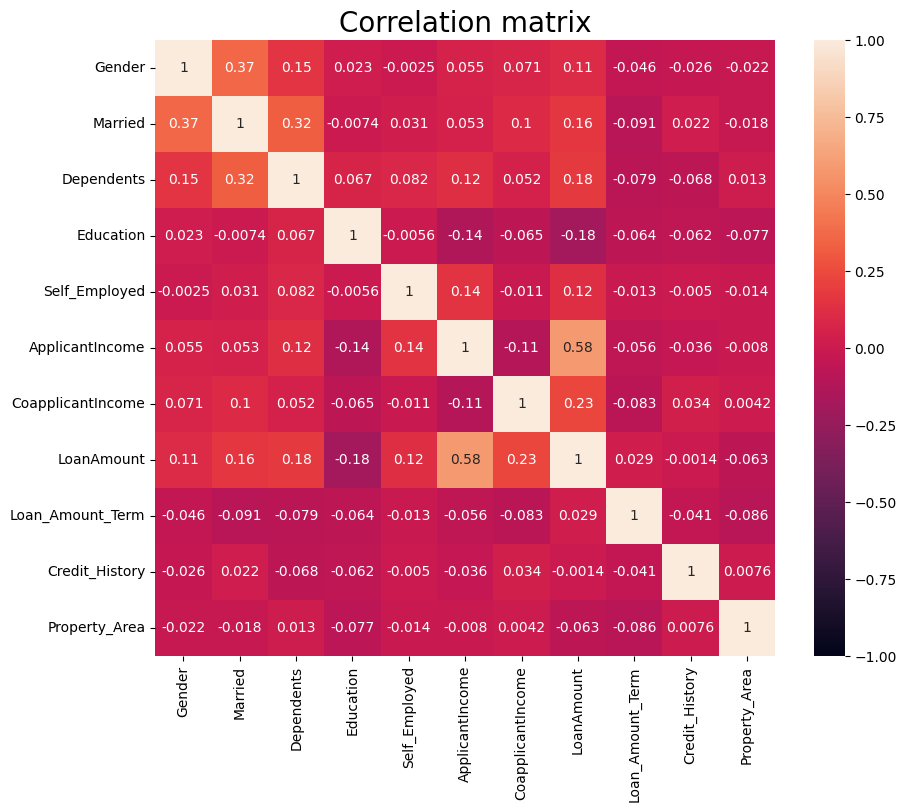

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

random_state = 0
file = pd.read_csv("credit.csv").drop(columns=["Loan_ID"])  # Charge le fichier CSV et supprime la colonne 'Loan_ID' (identifiant inutile)

# Discriminate categorical features and numerical features
cat_col = file.select_dtypes(include="object").columns.tolist() + ["Credit_History"]  # Liste des colonnes catégorielles (texte + historique de crédit)
num_col = file.select_dtypes(exclude="object").columns.tolist()  # Liste des colonnes numériques
num_col.remove("Credit_History")  # On retire 'Credit_History' des colonnes numériques car elle est traitée comme catégorielle

# Transform categorical features to integer array
enc = OrdinalEncoder()
file[cat_col] = enc.fit_transform(file[cat_col])  # Transforme les variables catégorielles en entiers (codage ordinal)

# Fill missing values
imputer = KNNImputer()
imputer.set_output(transform="pandas")
file = imputer.fit_transform(file)  # Imputation des valeurs manquantes par K plus proches voisins
file[cat_col] = file[cat_col].round()  # On arrondit les colonnes catégorielles pour rester sur des entiers

# Standardize numerical features
sts = StandardScaler()
file[num_col] = sts.fit_transform(file[num_col])  # Standardise les colonnes numériques (centrées réduites)

# print(file.dtypes)

X = file.iloc[:, :-1]  # Séparation des features
y = file.iloc[:, -1]  # Cible = dernière colonne

X_train, X_test, y_train, y_test = train_test_split(  # Découpe des données en train/test (80% / 20%)
    X, y, test_size=0.2, random_state=random_state
)

plt.figure(figsize=(10, 8))
sns.heatmap(  # Affiche la matrice de corrélation entre les variables d'entrée
    pd.DataFrame(X_train, columns=X_train.columns.tolist()).corr(),  # Calcul des corrélations à partir de X_train
    vmin=-1,
    annot=True,
)
plt.title("Correlation matrix", fontsize=20)
plt.show()


2/ A présent, utiliser Boruta avec un RandomForestClassifier pour sélectionner
automatiquement les features importantes. Combien et quelles sont les features
sélectionnées ?

In [6]:
from sklearn.ensemble import RandomForestClassifier  # Modèle de classification par forêts aléatoires
from sklearn.metrics import ConfusionMatrixDisplay  # Pour afficher une matrice de confusion
from sklearn.model_selection import RandomizedSearchCV  # Recherche aléatoire d’hyperparamètres
!pip install boruta
from boruta import BorutaPy  # Sélection de variables basée sur Random Forest
import numpy as np  # Pour les plages de valeurs dans les hyperparamètres

# Fonction d'optimisation des hyperparamètres via RandomizedSearchCV
def optimize_hyperparameters(X, y, estimator, param_distributions):
    randomized_search = RandomizedSearchCV(
        estimator=estimator,  # Modèle à optimiser
        param_distributions=param_distributions,  # Dictionnaire des plages d'hyperparamètres
        scoring="accuracy",  # Utilise la précision comme métrique
        n_jobs=-1,  # Utilise tous les cœurs CPU
        cv=5,  # Validation croisée 5-fold
        random_state=random_state  # Graine pour reproductibilité
    )
    randomized_search.fit(X, y)  # Lance la recherche et l'entraînement
    print(randomized_search.best_params_)  # Affiche les meilleurs paramètres trouvés
    return randomized_search  # Retourne le modèle optimisé

# Fonction de sélection des meilleures variables via Boruta
def select_features(X, y, estimator):
    feat_selector = BorutaPy(
        estimator=estimator,  # Modèle de base pour l'importance des features
        n_estimators="auto",  # Nombre d'arbres automatique
        max_iter=10  # Nombre maximum d'itérations Boruta
    )
    feat_selector.fit(X.values, y.values)  # Applique Boruta

    print("\n------Support and Ranking for each feature------")
    for i in range(len(feat_selector.support_)):
        if feat_selector.support_[i]:  # Si la feature est sélectionnée
            print("Passes the test: ", X.columns[i], " - Ranking: ", feat_selector.ranking_[i])
        else:  # Sinon, elle est rejetée
            print("Doesn't pass the test: ", X.columns[i], " - Ranking: ", feat_selector.ranking_[i])

    return X.loc[:, feat_selector.support_]  # Retourne uniquement les features sélectionnées

# Définition de l’espace de recherche des hyperparamètres
param_distributions = {
    "n_estimators": [int(x) for x in np.linspace(start=10, stop=500, num=10)],  # Nb d'arbres
    "criterion": ["gini", "entropy"],  # Critère de division
    "max_depth": [None] + [int(x) for x in np.linspace(start=1, stop=100, num=10)],  # Profondeur max
    "min_samples_split": [int(x) for x in np.linspace(start=2, stop=50, num=5)],  # Nb min pour splitter un nœud
    "min_samples_leaf": [int(x) for x in np.linspace(start=1, stop=50, num=5)],  # Nb min dans une feuille
    "max_features": [None, "sqrt", "log2"],  # Nb de variables testées par split
    "bootstrap": [True, False],  # Utilise ou non le bootstrap
}

# Exemple d'utilisation :
# (Supposons que X_train, y_train et random_state soient déjà définis dans ton script principal)

# Entraîne un modèle simple (non optimisé)
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)

# Sélectionne les meilleures variables avec Boruta
X_train_selected = select_features(
    X=X_train,
    y=y_train,
    estimator=RandomForestClassifier(class_weight="balanced")
)

# (Optionnel) Optimisation des hyperparamètres avec les features sélectionnées
# optimized_model = optimize_hyperparameters(X_train_selected, y_train, rf, param_distributions)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.5 MB/s eta 0:00:00

------Support and Ranking for each feature------
Doesn't pass the test:  Gender  - Ranking:  10
Doesn't pass the test:  Married  - Ranking:  8
Doesn't pass the test:  Dependents  - Ranking:  6
Doesn't pass the test:  Education  - Ranking:  9
Doesn't pass the test:  Self_Employed  - Ranking:  10
Doesn't pass the test:  ApplicantIncome  - Ranking:  2
Doesn't pass the test:  CoapplicantIncome  - Ranking:  4
Doesn't pass the test:  LoanAmount  - Ranking:  3
Doesn't pass the test:  Loan_Amount_Term  - Ranking:  7
Passes the test:  Credit_History  - Ranking:  1
Doesn't pass the test:  Property_Area  - Ranking:  5


3/ Créer un nouveau dataset ne contenant que les features sélectionnées par Boruta.
Réappliquez tout le pipeline de sélection de modèle sur ce nouveau dataset et comparez les
résultats obtenus sur le dataset complet. Qu’en pensez-vous ?

{'n_estimators': 500, 'min_samples_split': 38, 'min_samples_leaf': 13, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


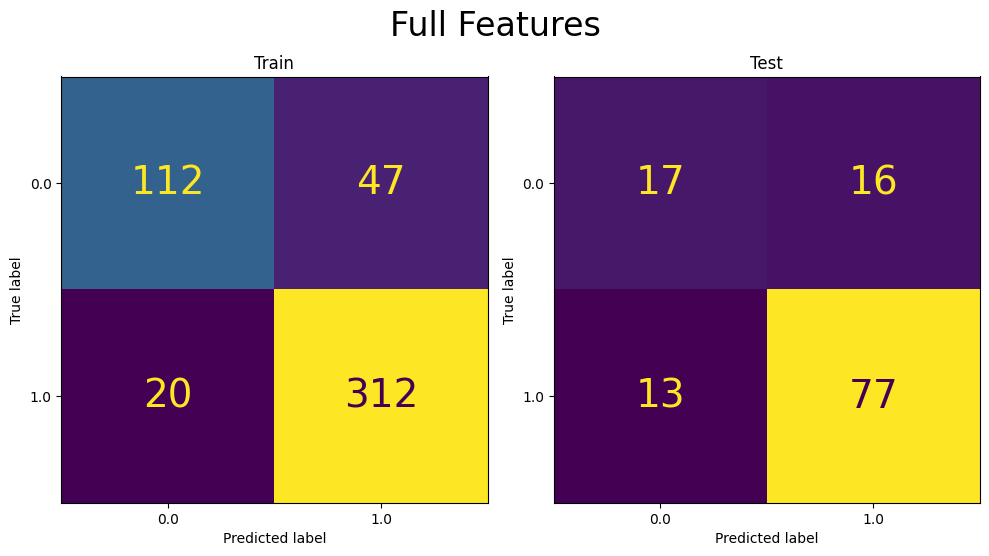

=== Classification Report: Full Features ===
              precision    recall  f1-score   support

         0.0       0.57      0.52      0.54        33
         1.0       0.83      0.86      0.84        90

    accuracy                           0.76       123
   macro avg       0.70      0.69      0.69       123
weighted avg       0.76      0.76      0.76       123

{'n_estimators': 173, 'min_samples_split': 50, 'min_samples_leaf': 50, 'max_features': None, 'max_depth': 56, 'criterion': 'gini', 'bootstrap': False}


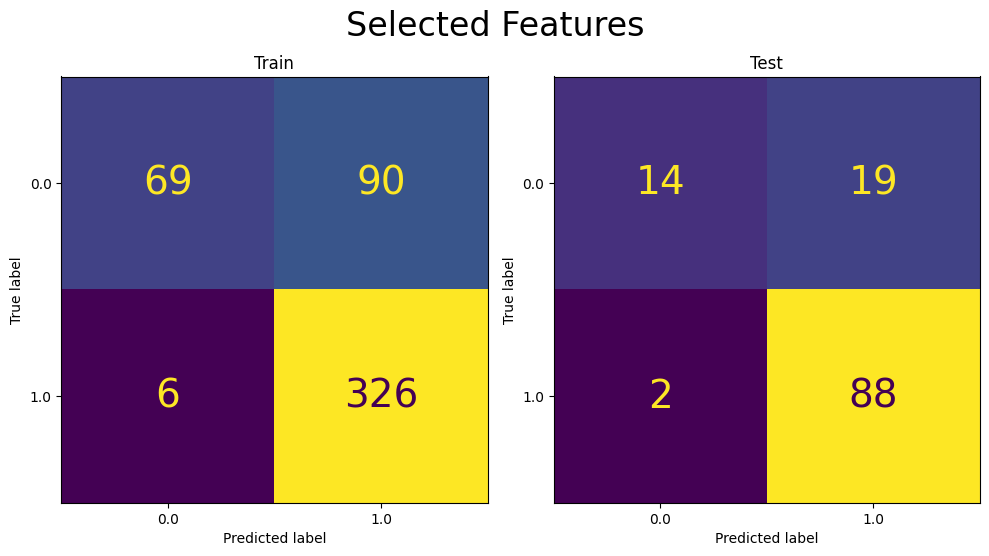

=== Classification Report: Selected Features ===
              precision    recall  f1-score   support

         0.0       0.88      0.42      0.57        33
         1.0       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



In [7]:
from sklearn.metrics import classification_report  # Pour afficher précision, rappel, f1-score

def plot_confusion_matrix(estimator, X_train, y_train, X_test, y_test, title="Confusion Matrix"):  # Fonction d'affichage complet
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Deux sous-graphes côte à côte
    axs = axs.flatten()  # Aplatit la liste pour accéder directement à axs[0] et axs[1]

    ConfusionMatrixDisplay.from_estimator(estimator, X_train, y_train, ax=axs[0], text_kw={"fontsize": 28}, colorbar=False)  # Matrice de confusion sur le train
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, ax=axs[1], text_kw={"fontsize": 28}, colorbar=False)  # Matrice sur le test

    axs[0].set_title("Train")  # Titre à gauche
    axs[1].set_title("Test")  # Titre à droite
    plt.tight_layout()  # Ajuste l'espacement
    plt.suptitle(title, fontsize=24, y=0.78)  # Titre global de la figure
    plt.show()  # Affiche le tout

    print(f"=== Classification Report: {title} ===")  # Affiche un titre pour le rapport
    print(classification_report(y_test, estimator.predict(X_test)))  # Affiche les métriques sur le test


# Entraînement d’un Random Forest optimisé sur toutes les features
rf_full = optimize_hyperparameters(
    X=X_train,  # Données d'entraînement complètes
    y=y_train,  # Labels
    estimator=RandomForestClassifier(class_weight="balanced"),  # Gère les classes déséquilibrées
    param_distributions=param_distributions,  # Hyperparamètres à tester
).best_estimator_  # On garde le meilleur modèle trouvé

plot_confusion_matrix(rf_full, X_train, y_train, X_test, y_test, title="Full Features")  # Affiche les résultats de ce modèle


# Entraînement d’un Random Forest optimisé sur les features sélectionnées
X_test_selected = X_test[X_train_selected.columns]  # Garde les mêmes colonnes que celles filtrées par Boruta

rf_simplified = optimize_hyperparameters(
    X=X_train_selected,  # Données d'entraînement réduites
    y=y_train,
    estimator=RandomForestClassifier(class_weight="balanced"),
    param_distributions=param_distributions,
).best_estimator_

plot_confusion_matrix(
    rf_simplified,
    X_train_selected,
    y_train,
    X_test_selected,
    y_test,
    title="Selected Features"
)


Exercice 2 : Explicabilité

1/  En  partant  du  meilleur  modèle  obtenu  sur  le  dataset  complet  (qui  sera  plus  intéressant
pour cet exercice sur l’explicabilité), afficher, analyser et expliquer un summary plot obtenu
en utilisant les SHap Values.

 98%|===================| 959/982 [00:30<00:00]       

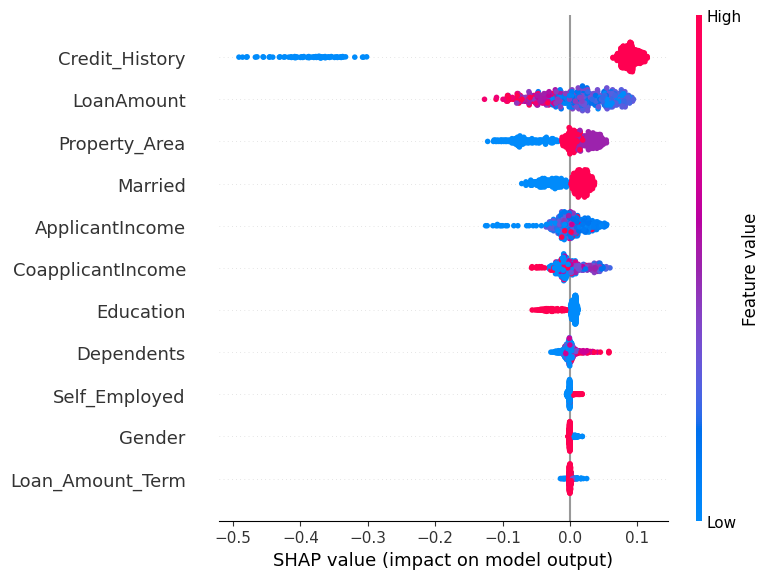

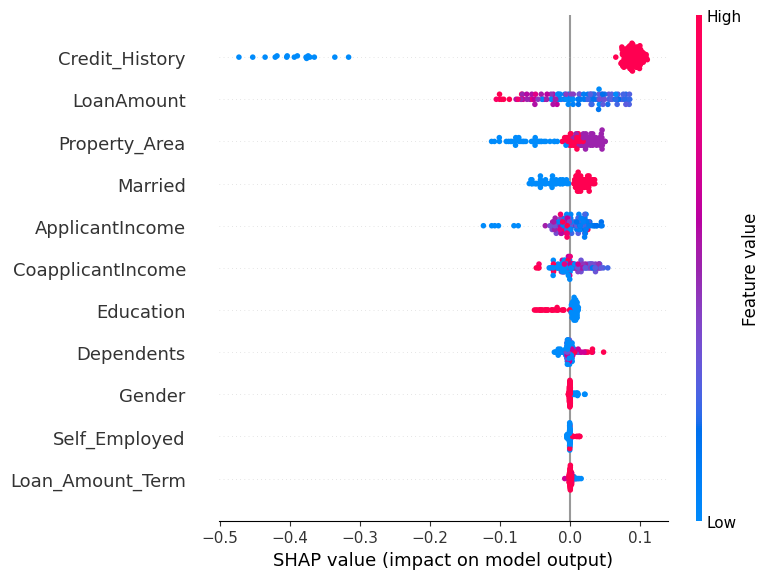

In [8]:
import shap  # Bibliothèque pour interpréter les modèles machine learning

def explain(model, X_train, X_test):  # Fonction pour expliquer les prédictions du modèle avec SHAP
    explainer = shap.TreeExplainer(model, X_train)  # Crée un explainer adapté aux modèles arborescents (Random Forest, XGBoost, etc.)
    shap_values_train = explainer(X_train, check_additivity=False)  # Calcule les valeurs SHAP sur le jeu d'entraînement
    shap_values_test = explainer(X_test, check_additivity=False)  # Calcule les valeurs SHAP sur le jeu de test

    shap.summary_plot(shap_values_train[:, :, 1], X_train)  # Résumé des contributions SHAP pour la classe 1 (train)
    shap.summary_plot(shap_values_test[:, :, 1], X_test)  # Résumé des contributions SHAP pour la classe 1 (test)

# Appel de la fonction pour expliquer le modèle entraîné sur toutes les features
explain(
    model=rf_full,  # Modèle Random Forest complet
    X_train=X_train,  # Données d'entraînement
    X_test=X_test   # Données de test
)


2/ Afficher et analyser les ICE plots de chacune des features du dataset.

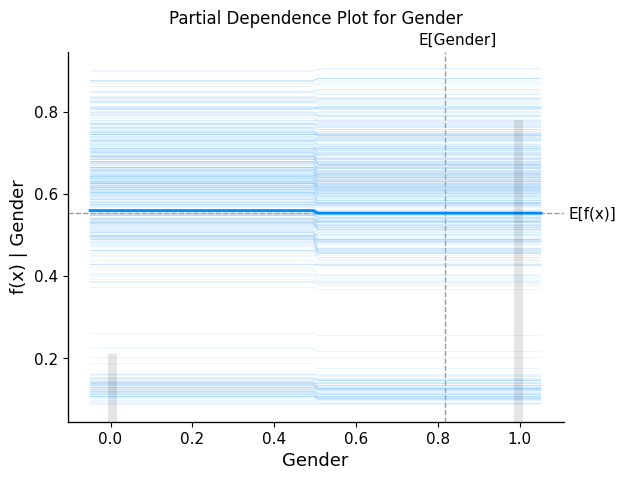

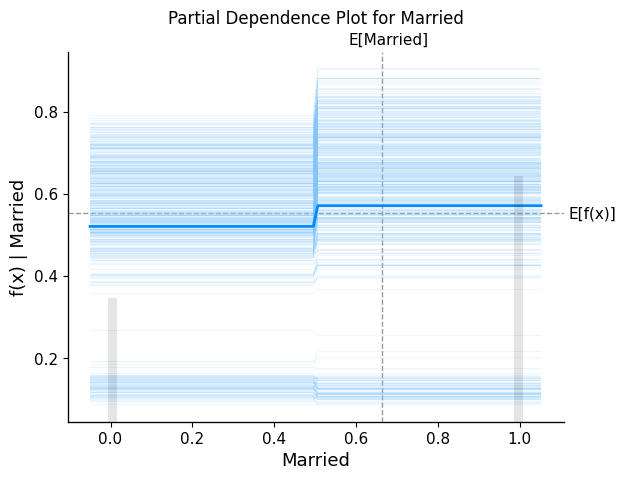

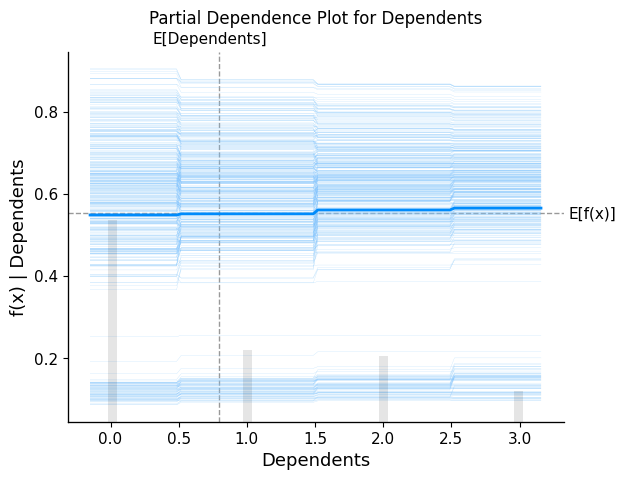

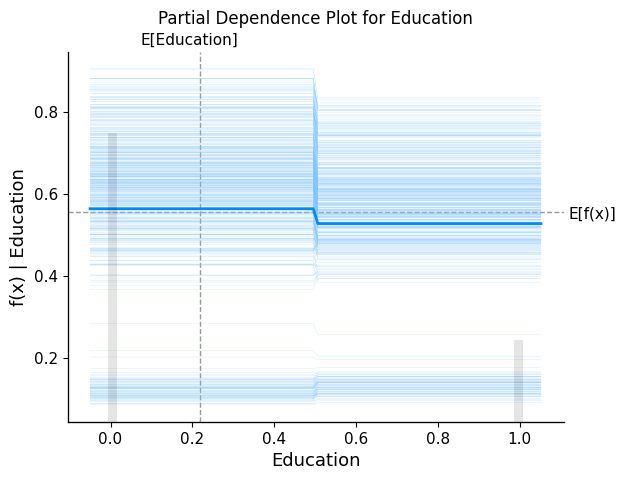

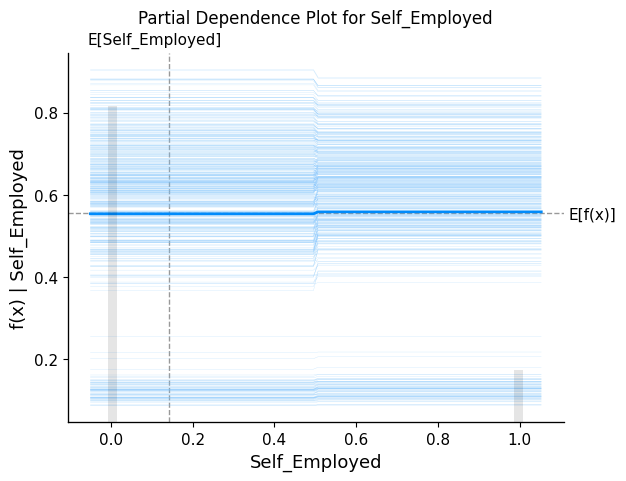

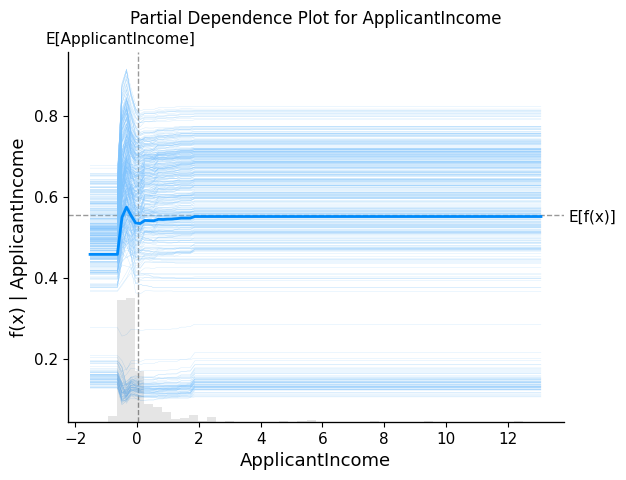

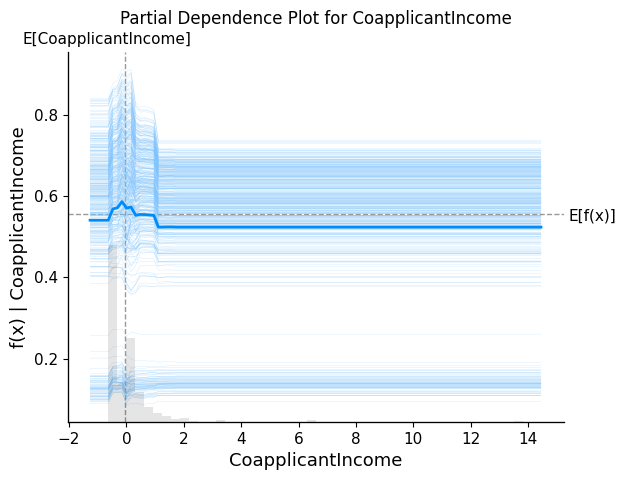

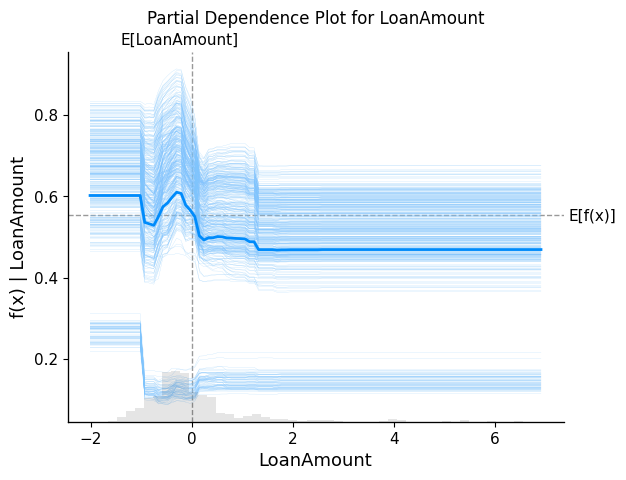

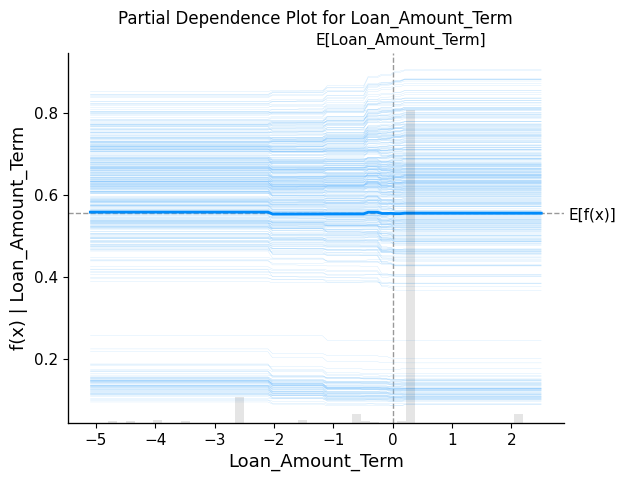

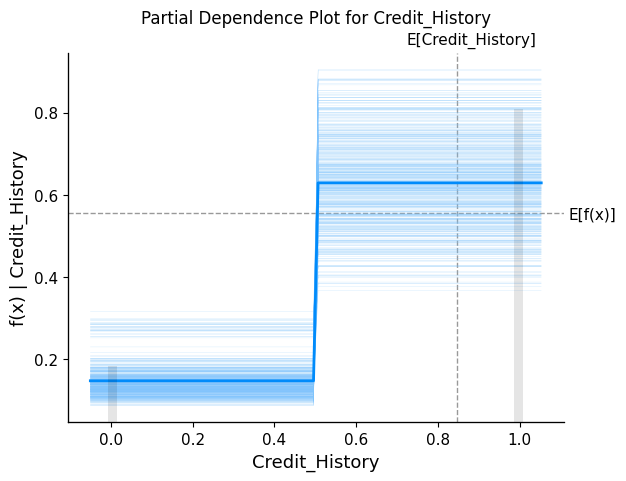

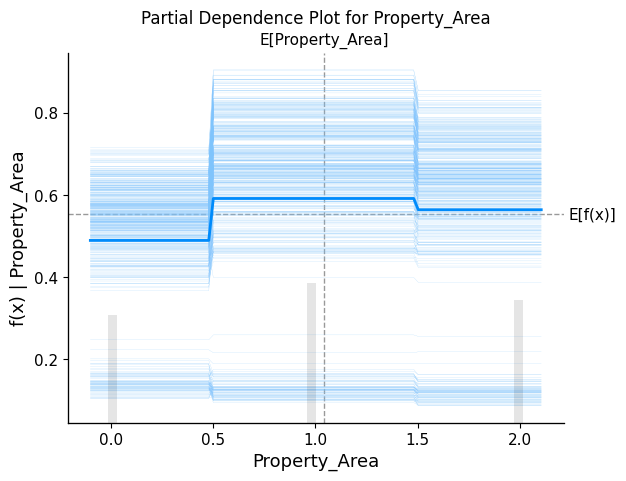

In [11]:
def plot_ICE(model, X):  # Fonction pour afficher les courbes de dépendance partielle (ou ICE) pour chaque variable
    for i, feature in enumerate(X.columns.tolist()):  # Parcours toutes les features du dataset
        shap.plots.partial_dependence(  # Trace la courbe de dépendance partielle pour une feature donnée
            feature,  # La variable à expliquer
            lambda x: model.predict_proba(x)[:, 1],  # Fonction de prédiction : probabilité d'appartenir à la classe 1
            X,  # Données sur lesquelles on applique la simulation
            model_expected_value=True,  # Affiche la prédiction moyenne du modèle
            feature_expected_value=True,  # Affiche la valeur moyenne de la feature
            show=False,  # Empêche SHAP d'afficher automatiquement (on utilise plt.show() après pour personnaliser)
        )
        plt.title(f"Partial Dependence Plot for {feature}")  # Titre du graphe
        plt.show()  # Affiche le graphe pour la feature actuelle

# Appel de la fonction pour visualiser l'effet de chaque variable sur les prédictions
plot_ICE(rf_full, X_train)


3/  Quelles  informations  sur  le  fonctionnement  du  modèle  tirez-vous  de  cette  analyse.
Attention, chaque modèle peut avoir un fonctionnement différent !

- Matrice de confusion:
Les matrices de confusion du modèle d'entraînement et du modèle de test sont identiques, donc l'algorithme Boruta a réussi à simplifier le modèle sans diminuer les performances de prédiction.
![image-3.png](attachment:image-3.png)
- summary_plot:
![image-4.png](attachment:image-4.png)
![image-5.png](attachment:image-5.png)
- Plot ICE
![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

Exercice 3 : Ajout des derniers algorithmes de ML

1/ Ajouter et optimiser XGBoost à votre pipeline de sélection de modèles. En particulier,
vous devriez évaluer différentes profondeurs maximales d’arbres (entre 3 et 10), différents
nombres de pondérations par feuille (min_child_weight, entre 1 et 10), différentes valeurs
de gamma (entre 0 et 5), différents taux d’apprentissage (entre 0.01 et 0.3) et différents
nombres d’estimateurs (entre 25 et 200). Vous regarderez avant cela l’impact de ces
paramètres sur l’apprentissage.

{'n_estimators': 132, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': np.float64(0.14020408163265308), 'gamma': np.float64(0.6122448979591837)}


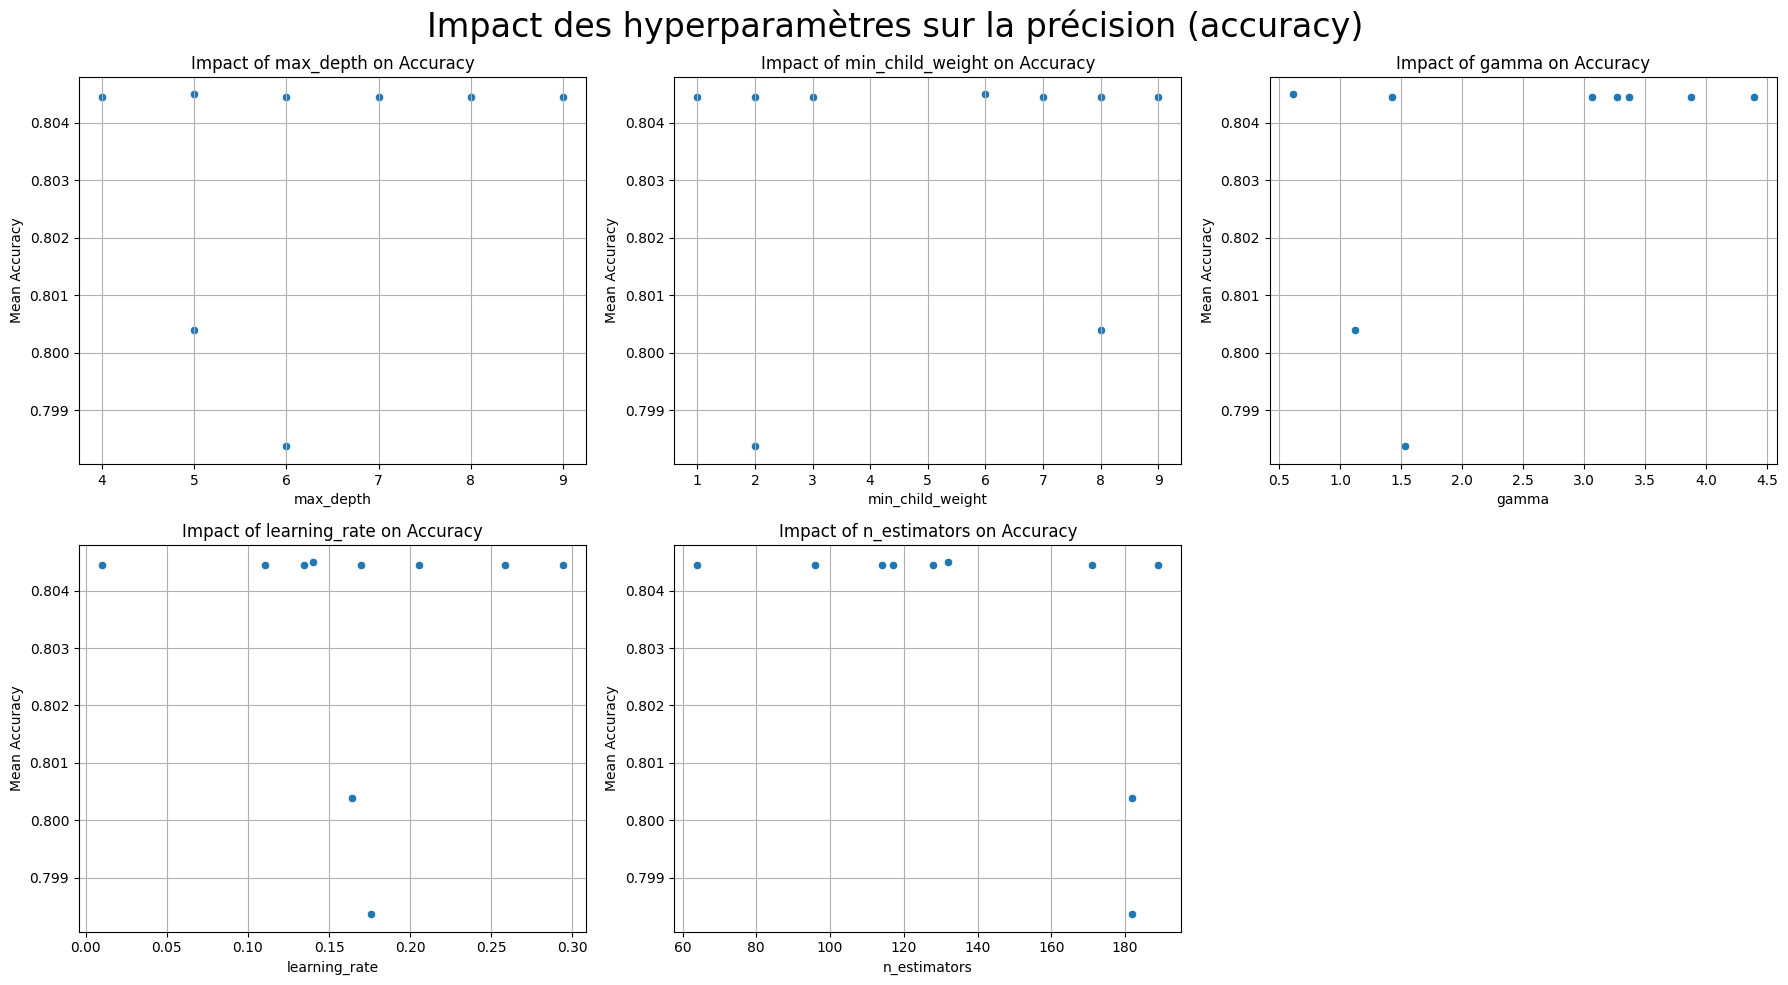

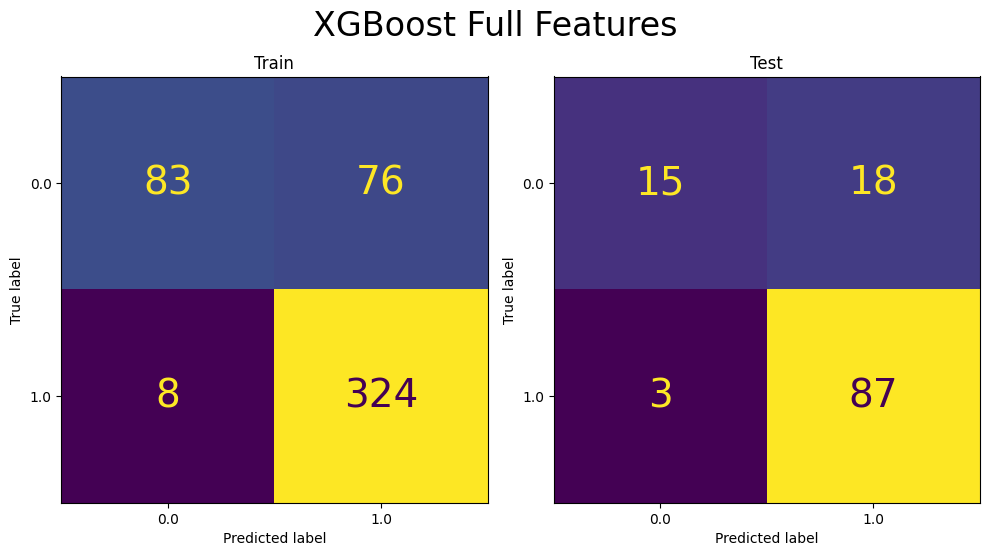

=== Classification Report: XGBoost Full Features ===
              precision    recall  f1-score   support

         0.0       0.83      0.45      0.59        33
         1.0       0.83      0.97      0.89        90

    accuracy                           0.83       123
   macro avg       0.83      0.71      0.74       123
weighted avg       0.83      0.83      0.81       123



In [12]:
from xgboost import XGBClassifier  # Importe le classifieur XGBoost

# Dictionnaire des hyperparamètres à tester pour XGBoost (plages)
param_distributions = {
    "max_depth": [int(x) for x in np.linspace(start=3, stop=10)],  # Profondeur max de chaque arbre
    "min_child_weight": [int(x) for x in np.linspace(start=1, stop=10)],  # Nb min d’échantillons dans une feuille
    "gamma": [x for x in np.linspace(start=0, stop=5)],  # Seuil de gain minimum pour effectuer un split
    "learning_rate": [x for x in np.linspace(start=0.01, stop=0.3)],  # Taux d’apprentissage (shrinkage)
    "n_estimators": [int(x) for x in np.linspace(start=25, stop=200)],  # Nombre d’arbres à construire
}

# Recherche aléatoire d’hyperparamètres avec validation croisée
search_result = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=XGBClassifier(
        objective="binary:logistic",  # Pour un problème de classification binaire
        eval_metric="logloss",  # Métrique à optimiser pendant l'entraînement
        random_state=random_state
    ),
    param_distributions=param_distributions
)

# Stocke tous les résultats de validation croisée dans un DataFrame
cv_results = pd.DataFrame(search_result.cv_results_)

# Affiche un scatterplot de l'effet de chaque hyperparamètre sur la précision
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 6 graphes (on en utilisera que 5)
axs = axs.flatten()

for i, param in enumerate(param_distributions.keys()):
    sns.scatterplot(data=cv_results, x=f"param_{param}", y="mean_test_score", ax=axs[i])  # Affiche la précision moyenne en fonction du paramètre testé
    axs[i].set_title(f"Impact of {param} on Accuracy")
    axs[i].set_xlabel(param)
    axs[i].set_ylabel("Mean Accuracy")
    axs[i].grid(True)

fig.delaxes(axs[-1])  # Supprime le 6e graphique vide
plt.suptitle("Impact des hyperparamètres sur la précision (accuracy)", fontsize=24)
plt.tight_layout()
plt.show()

# Récupère le meilleur modèle trouvé
model = search_result.best_estimator_

# Affiche les matrices de confusion + classification report pour ce modèle
plot_confusion_matrix(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    title="XGBoost Full Features"
)


2/ Ajouter et tester différentes architectures de perceptron multicouche. Voici deux
exemples à tester :
- 2 couches cachées avec une fonction d’activation ReLU : 1ère de 64 neurones et 2nde
de 32 neurones
- 3 couches cachées avec une fonction d’activation ReLU : 1ère de 128 neurones, 2nde
de 64 neurones et une 3ème de 32 neurones
Vous pourrez tester toute autre architecture de votre choix.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


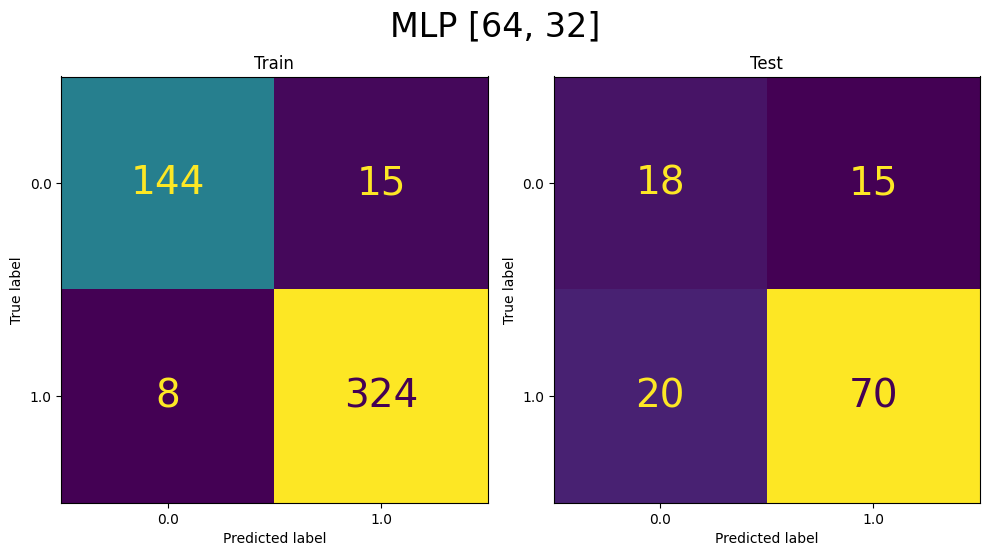

=== Classification Report: MLP [64, 32] ===
              precision    recall  f1-score   support

         0.0       0.47      0.55      0.51        33
         1.0       0.82      0.78      0.80        90

    accuracy                           0.72       123
   macro avg       0.65      0.66      0.65       123
weighted avg       0.73      0.72      0.72       123



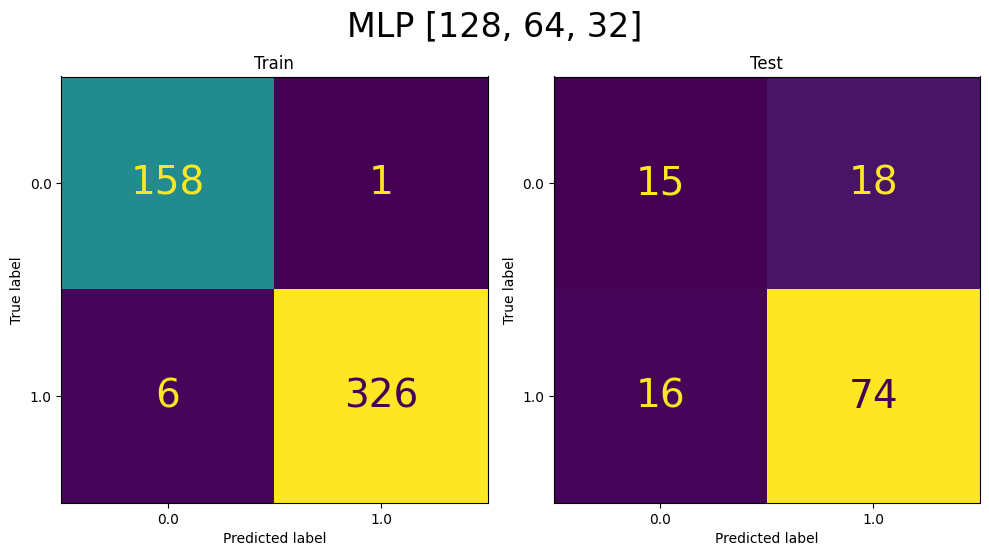

=== Classification Report: MLP [128, 64, 32] ===
              precision    recall  f1-score   support

         0.0       0.48      0.45      0.47        33
         1.0       0.80      0.82      0.81        90

    accuracy                           0.72       123
   macro avg       0.64      0.64      0.64       123
weighted avg       0.72      0.72      0.72       123



In [13]:
from sklearn.neural_network import MLPClassifier  # Importe le perceptron multicouche (réseau de neurones)

# Définition d’un premier modèle MLP avec 2 couches cachées : 64 neurones → 32 neurones
mlp2 = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Architecture du réseau
    activation="relu",  # Fonction d’activation ReLU
    solver="adam",  # Optimiseur Adam (rapide et robuste)
    max_iter=500,  # Nombre max d’itérations d'entraînement
    random_state=random_state  # Graine pour reproductibilité
)

# Deuxième modèle avec 3 couches cachées : 128 → 64 → 32 neurones
mlp3 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=random_state
)

# Dictionnaire des modèles à tester
models = {
    "MLP [64, 32]": mlp2,
    "MLP [128, 64, 32]": mlp3,
}

# Entraîne et affiche les résultats pour chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)  # Entraîne le modèle sur les données d’entraînement
    plot_confusion_matrix(  # Affiche matrices + classification report
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        title=name  # Utilise le nom du modèle comme titre
    )


3/ Relancer votre pipeline sur le dataset et évaluer l’intérêt de ces nouveaux algorithmes
pour ce dataset.

Exercice 4 : Construire un pipeline pour la régression (à faire à la
maison)

Reprendre ce même travail pour un dataset de régression proposé en tronc commun
(insurance).